In [120]:
import pandas as pd
import h5py as h5
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

Utils Functions (to import)

In [96]:
def get_joint_prob_distr(target, source_var1, source_var2, source_var3):
    
    count = len(source_var1)

    # compute probabilities from (multi-dim) histogram frequencies
    result, _ = np.histogramdd(
        np.vstack([source_var1, source_var2, source_var3, target]).T, 
        bins=[np.max(source_var1), np.max(source_var2), np.max(source_var3), np.max(target)]
    )
    
    return result / count

In [78]:
def get_SUI(joint_prob_distr):

    # get dimensions
    dim_x_past = joint_prob_distr.shape[0]
    dim_y_pres = joint_prob_distr.shape[1]
    dim_y_past = joint_prob_distr.shape[2]
    dim_s = joint_prob_distr.shape[3]

    # initialize arrays
    spec_surprise_x = np.zeros(dim_s)
    spec_surprise_y = np.zeros(dim_s)
    spec_surprise_y_past = np.zeros(dim_s)

    # compute specific information provided by each source variable about s (target)
    for s in range(dim_s):

        # p(s)
        ps = np.sum(joint_prob_distr[:, :, :, s]) 

        # info provided by x past
        for x in range(dim_x_past):
            psx = np.sum(joint_prob_distr[x, :, :, s]) / (np.sum(joint_prob_distr[x, :, :, :]) + np.finfo(float).eps)
            pxs = np.sum(joint_prob_distr[x, :, :, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)

            spec_surprise_x[s] += pxs * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psx + np.finfo(float).eps)))

        # info provided by y
        for y in range(dim_y_pres):
            psy = np.sum(joint_prob_distr[:, y, :, s]) / (np.sum(joint_prob_distr[:, y, :, :]) + np.finfo(float).eps)
            pys = np.sum(joint_prob_distr[:, y, :, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)
            
            spec_surprise_y[s] += pys * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psy + np.finfo(float).eps)))

        # info provided by y past
        for y in range(dim_y_past):
            psy = np.sum(joint_prob_distr[:, :, y, s]) / (np.sum(joint_prob_distr[:, :, y, :]) + np.finfo(float).eps)
            pys = np.sum(joint_prob_distr[:, :, y, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)
            
            spec_surprise_y_past[s] += pys * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psy + np.finfo(float).eps)))

    # compute IMin

    IMin_x_y_ypast = 0
    IMin_x_y = 0

    for s in range(dim_s):
        IMin_x_y_ypast += np.sum(joint_prob_distr[:, :, :, s]) * min(spec_surprise_x[s], spec_surprise_y[s], spec_surprise_y_past[s])
        IMin_x_y += np.sum(joint_prob_distr[:, :, :, s]) * min(spec_surprise_x[s], spec_surprise_y[s])

    return IMin_x_y - IMin_x_y_ypast

In [79]:
def compute_TE(joint_prob_distr):

    p_ypast = np.sum(joint_prob_distr, axis=(0, 1, 3))
    p_x_ypast = np.sum(joint_prob_distr, axis=(1, 3))
    p_y_ypast = np.sum(joint_prob_distr, axis=(0, 3))
    p_x_y_ypast = np.sum(joint_prob_distr, axis=3)
    
    def entropy(p):
        p_nonzero = p[p > 0]  # Avoid log of zero
        return - np.sum(p_nonzero * np.log2(p_nonzero))
    
    h_ypast = entropy(p_ypast)
    h_x_ypast = entropy(p_x_ypast)
    h_y_ypast = entropy(p_y_ypast)
    h_x_y_ypast = entropy(p_x_y_ypast)
    
    return h_y_ypast - h_ypast - h_x_y_ypast + h_x_ypast

In [80]:
def compute_DFI(joint_prob_distr):
    
    # marginal distributions
    prob_ypast = np.sum(joint_prob_distr, axis=(0, 1, 3))
    prob_x_ypast = np.sum(joint_prob_distr, axis=(1, 3))
    prob_y_ypast = np.sum(joint_prob_distr, axis=(0, 3))
    prob_ypast_s = np.sum(joint_prob_distr, axis=(0, 1))
    prob_x_y_ypast = np.sum(joint_prob_distr, axis=3)
    prob_y_ypast_s = np.sum(joint_prob_distr, axis=0)
    prob_x_ypast_s = np.sum(joint_prob_distr, axis=1)
    
    def get_entropy(prob_dist):
        prob_nonzero = prob_dist[prob_dist > 0]  # Filter out zero values
        return -np.sum(prob_nonzero * np.log2(prob_nonzero))
    
    # entropies
    h_ypast = get_entropy(prob_ypast)
    h_x_ypast = get_entropy(prob_x_ypast)
    h_y_ypast = get_entropy(prob_y_ypast)
    h_ypast_s = get_entropy(prob_ypast_s)
    h_x_y_ypast = get_entropy(prob_x_y_ypast)
    h_y_ypast_s = get_entropy(prob_y_ypast_s)
    h_x_ypast_s = get_entropy(prob_x_ypast_s)
    h_x_y_ypast_s = get_entropy(joint_prob_distr)
    
    # compute DFI
    dfi = h_y_ypast - h_ypast - h_x_y_ypast + h_x_ypast - h_y_ypast_s + h_ypast_s + h_x_y_ypast_s - h_x_ypast_s
    
    return dfi

In [81]:
def compute_FIT_TE_DFI(feature, X, Y, hY, xtrap=20):
    # Build the two four-variables probability distributions needed to compute FIT
    pXYhYS = get_joint_prob_distr(feature, X, Y, hY)    # probability distribution for the PID with (Xp, Yp, Yt) as sources and S as target
    pXShYY = get_joint_prob_distr(Y, X, feature, hY)    # probability distribution for the PID with (Xp, Yp, S) as sources and Yt as target

    # Compute the two FIT atoms and FIT
    sui_S = get_SUI(pXYhYS)
    sui_Y = get_SUI(pXShYY)

    fit = np.min([sui_S, sui_Y])

    # Compute TE
    te = compute_TE(pXYhYS)

    # Compute DFI
    dfi = compute_DFI(pXYhYS)

    # Compute quadratic extrapolation bias correction for FIT and TE
    fit_all = fit
    te_all = te

    FIT2 = np.zeros(xtrap)
    FIT4 = np.zeros(xtrap)
    TE2 = np.zeros(xtrap)
    TE4 = np.zeros(xtrap)

    for xIdx in range(xtrap):

        numberOfTrials = len(X)

        # Shuffled indexes in 0,ntrials range
        rIdx = npr.choice(numberOfTrials, numberOfTrials, replace=False)
        
        # Divide the indexes in 2 and 4 parts
        idx2 = np.array_split(rIdx, 2) 
        idx4 = np.array_split(rIdx, 4)
        
        # Stack all the sources in data, separate into 2 and 4 parts, and distinguish between s and y targets
        data = np.stack(np.array([feature, X, Y, hY]),axis=1)
        data2_s = np.stack(np.array([data[idx2[i]] for i in range(2)]), axis = 0)
        data2_y = data2_s[:, :, [2, 1, 0, 3]]
        data2_tot = np.stack(np.array([data2_s,data2_y]), axis=0)
        
        data4_s = np.stack(np.array([data[idx4[i]] for i in range(4)]), axis = 0)
        data4_y = data4_s[:, :, [2, 1, 0, 3]]
        data4_tot = np.stack(np.array([data4_s,data4_y]), axis=0)
        
        # Compute Joint, SUI, FIT and TE for the 2 divided version
        joint2 = [[
            get_joint_prob_distr(*[data2_tot[ch,row, :, i] for i in range(4)])
            for row in range(data2_tot.shape[1])]
            for ch in range(data2_tot.shape[0])
        ]
        
        SUI_2 = [[get_SUI(joint2[ch][i]) for i in range(2)] for ch in range(len(joint2))]
        FIT2[xIdx] = np.mean(np.min(SUI_2,axis=0))
        TE2[xIdx] = np.mean([compute_TE(joint2[0][i]) for i in range(2)])
        
        # Compute Joint, SUI, FIT and TE for the 4 divided version
        joint4 = [[
            get_joint_prob_distr(*[data4_tot[ch,row, :, i] for i in range(4)])
            for row in range(data4_tot.shape[1])]
            for ch in range(data4_tot.shape[0])
        ]
        
        SUI_4 = [[get_SUI(joint4[ch][i]) for i in range(4)] for ch in range(len(joint4))]
        FIT4[xIdx] = np.mean(np.min(SUI_4,axis=0))
        TE4[xIdx] = np.mean([compute_TE(joint4[0][i]) for i in range(4)])

    # Compute the linear and quadratic interpolations for FIT and TE

    x = [1/len(idx2[0]), 1/len(idx4[0]), 1/len(rIdx)]
    y = [np.mean(FIT4), np.mean(FIT2), fit_all]

    p2 = np.polyfit(x, y, 2)
    p1 = np.polyfit(x, y, 1) 
    FITQe = p2[2]
    FITLe = p1[1]
         
    y = [np.mean(TE4), np.mean(TE2), te_all]
    
    p2 = np.polyfit(x, y, 2)
    p1 = np.polyfit(x, y, 1) 
    TEQe = p2[2]
    TELe = p1[1]

    return te, dfi, fit # , TEQe, TELe, FITQe, FITLe

Global Parameters

In [82]:
max_delay = 60
bins = 2

Metadata

In [83]:
meta_path = 'data/data/metadata.mat'
metadata = h5.File(meta_path,'r')

timesteps = len(metadata['time']) # Number of timesteps
num_files = int(np.array(metadata['Ns']).item()) # Number of files

Structures

In [84]:
left_fit = np.full((num_files, timesteps, max_delay), np.nan)
left_dfi = left_fit.copy()
left_di = left_fit.copy()
right_fit = left_fit.copy()
right_dfi = left_fit.copy()
right_di = left_fit.copy()

Computation

In [99]:
max_delay

60

In [ ]:
for file in range(1):
    print('File ',file+1)
    file_path = 'data/data/data_s{0}.mat'.format(file+1)
    data = h5.File(file_path,'r')

    eeg = np.array(data['feeg']) # eeg data
    left_electrode = np.array(data['LEmaxMI']).item() # Left electrode with max MI
    right_electrode = np.array(data['REmaxMI']).item() # Right electrode with max MI
    leeg = eeg[int(left_electrode),:,:]
    reeg = eeg[int(right_electrode),:,:]
    eye_visib = np.array(data['eyebubs']) # Visibility of eye region (related to stimulus)
    left_eye_v = eye_visib[0,:]
    right_eye_v = eye_visib[1,:]

    # Discretize stimulus
    _, bin_edges = pd.qcut(left_eye_v, bins, retbins=True)
    LES = np.digitize(left_eye_v, bins=bin_edges, right=True)
    _, bin_edges = pd.qcut(right_eye_v, bins, retbins=True)
    RES = np.digitize(right_eye_v, bins=bin_edges, right=True)

    # Computing temporal derivatives of eeg
    ldeeg = np.full(np.shape(leeg), np.nan)
    ldeeg[1:timesteps,:] = leeg[1:timesteps,:] - leeg[0:(timesteps-1),:]
    rdeeg = np.full(np.shape(reeg), np.nan)
    rdeeg[1:timesteps,:] = reeg[1:timesteps,:] - reeg[0:(timesteps-1),:]

    for temp in range(60):

        t = temp + 150
        print('Time: ',t)

        for d in range(max_delay):
            if((t-d)>0):
                    
                print('Delay: ',d)

                # Discretize Neural Signals
                _, bin_edges = pd.qcut(leeg[t,:], bins, retbins=True)
                leeg_d = np.digitize(leeg[t,:], bins=bin_edges, right=True)
                _, bin_edges = pd.qcut(ldeeg[t,:], bins, retbins=True)
                ldeeg_d = np.digitize(ldeeg[t,:], bins=bin_edges, right=True)
                _, bin_edges = pd.qcut(leeg[t-d,:], bins, retbins=True)
                leegp = np.digitize(leeg[t-d,:], bins=bin_edges, right=True)
                _, bin_edges = pd.qcut(ldeeg[t-d,:], bins, retbins=True)
                ldeegp = np.digitize(ldeeg[t-d,:], bins=bin_edges, right=True)

                _, bin_edges = pd.qcut(reeg[t,:], bins, retbins=True)
                reeg_d = np.digitize(reeg[t,:], bins=bin_edges, right=True)
                _, bin_edges = pd.qcut(rdeeg[t,:], bins, retbins=True)
                rdeeg_d = np.digitize(rdeeg[t,:], bins=bin_edges, right=True)
                _, bin_edges = pd.qcut(reeg[t-d,:], bins, retbins=True)
                reegp = np.digitize(reeg[t-d,:], bins=bin_edges, right=True)
                _, bin_edges = pd.qcut(rdeeg[t-d,:], bins, retbins=True)
                rdeegp = np.digitize(rdeeg[t-d,:], bins=bin_edges, right=True)

                # Left eye visibility, Right to left tranfer
                pastX = (reegp - 1) * bins + rdeegp
                Y = (leeg_d - 1) * bins + ldeeg_d
                pastY = (leegp - 1) * bins + ldeegp

                # Right Eye visibility, Left to Right transfer
                pastXR = (leegp - 1) * bins + ldeegp
                YR = (reeg_d - 1) * bins + rdeeg_d
                pastYR = (reegp - 1) * bins + rdeegp

                 
                right_di[file, t, d], right_dfi[file, t, d], right_fit[file, t, d] = compute_FIT_TE_DFI(RES, pastXR, YR, pastYR)
                                
                left_di[file, t, d], left_dfi[file, t, d], left_fit[file, t, d] = compute_FIT_TE_DFI(LES, pastX, Y, pastY)
                

In [118]:
right_fit[0,209,59]

0.0

Text(0, 0.5, 'Delay[ms]')

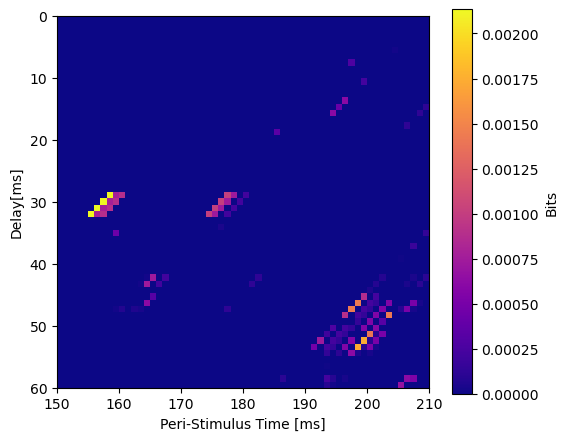

In [128]:
plt.figure(figsize=(6,5))
plt.imshow(right_fit[0,150:209,:],extent=[150,210,60,0],origin='lower',cmap='plasma')
plt.colorbar(label='Bits')
plt.xlabel('Peri-Stimulus Time [ms]')
plt.ylabel('Delay[ms]')

Text(0, 0.5, 'Delay[ms]')

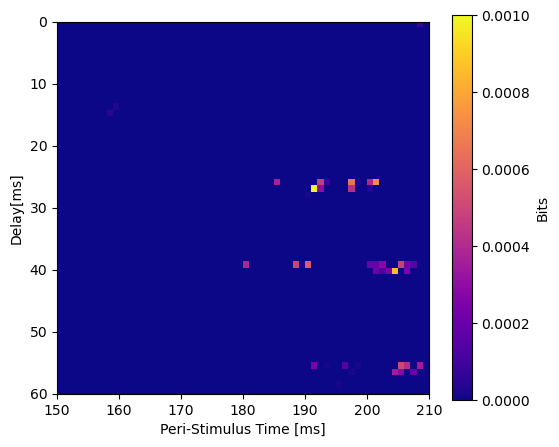

In [129]:
plt.figure(figsize=(6,5))
plt.imshow(left_fit[0,150:209,:],extent=[150,210,60,0],origin='lower',cmap='plasma')
plt.colorbar(label='Bits')
plt.xlabel('Peri-Stimulus Time [ms]')
plt.ylabel('Delay[ms]')